In [68]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mp
from matplotlib.collections import PatchCollection
import cv2
import os
import time

In [46]:
#folder for all the images created in between
RESPONSE_FOLDER = '/home/bhavy/Dropbox/8th-semester/computational cognitive science/assignments/assignment-2/response-time-experiment'

trils = [1, 2, 4, 6]
sqls =  [1, 1, 1, 1]

sizels = [2, 3, 5, 9]

#total number of triangles and Squares
TRIANGLES = 4
SQUARES = 1
#total no of objects
SIZE = TRIANGLES + SQUARES
#Experiment type
FEATURE = 'feature'
CONJUNCTION = 'conjunction'
#Marker size
#change only if you want to chnage the marker size
MARKER_SIZE = 500
SEED = 1

## Gabor Modules

In [57]:
def build_filters():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters
 
def process(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum

In [58]:
def create_gabor_image(filename):
    img = cv2.imread(filename, 0)
    #plt.imshow(img, cmap = 'gray')

    filters = build_filters()
    res1 = process(img, filters)

    cv2.imwrite('gabor-'+filename,res1)

In [64]:
#this function take file path and return number of corners in the image
def corners(filename):
    img =  cv2.imread(filename)

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray,5,3,0.04)


    ret, dst = cv2.threshold(dst,0.1*dst.max(),255,0)
    dst = np.uint8(dst)
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

    print(len(corners) -1)

    for i in range(1, len(corners)):
        print(corners[i])
    img[dst>0.1*dst.max()]=[0,0,255]


    img = img[:, :, ::-1]
    #plt.imshow(img)
    
    cv2.imwrite(os.path.join(RESPONSE_FOLDER,'corner-' + filename.split('/')[-1]) ,img)
    #plt.savefig('corners-square.jpg')
    
    return len(corners) - 1

In [55]:
def sq_or_triangle(no_of_corners):
    if no_of_corners == 4:
        print("The given shape is Square")
    elif no_of_corners == 3:
        print("The given shape is triangle")

## FIT Modules

In [34]:
#experiment type represent whether to use feature search where only one feature will be present such as shape or
#to use conjunction search where both color and shape will be present
#if nothing specified 
def generate_plot(TRIANGLES, SQUARES, SIZE,  experiment_type = 'feature'):
    np.random.seed(SEED)
    #plot  size
    fig=plt.figure(figsize=(7.5, 5), dpi= 80, facecolor='w', edgecolor='k')
    
    #generating co-ordinates uniformly
    a = np.random.uniform(-2, 2, SIZE).reshape(-1, 1)
    b = np.random.uniform(-2, 2, SIZE).reshape(-1, 1)
    #co-ordinates
    cord = np.concatenate((a,b), axis = 1)
    
    if experiment_type == 'feature':
        #marker ^ represents triangle and s represents square
        plt.scatter(cord[0:TRIANGLES, 0], cord[0:TRIANGLES, 1], marker='^', s =MARKER_SIZE, c = 'g')
        plt.scatter(cord[TRIANGLES: SIZE, 0], cord[TRIANGLES:SIZE, 1], marker='s', s =MARKER_SIZE, c = 'g')
        plt.xlim([-2.5, 2.5])
        plt.ylim([-2.5, 2.5])
        plt.axis('off')
        plt.savefig(os.path.join(RESPONSE_FOLDER, 'size-' + str(TRIANGLES + SQUARES)+  'simulation-feature.jpg'))
    else:
        for i in range(SIZE):
            #plotting triangles
            if i < TRIANGLES:
                #randomly deciding colors, half time red and half time blue
                if np.random.uniform()<0.5:
                    plt.scatter(cord[i, 0], cord[i, 1], marker='^', s =MARKER_SIZE, c = 'r')
                else:
                    plt.scatter(cord[i, 0], cord[i, 1], marker='^', s =MARKER_SIZE, c = 'b')
            #plotting squares
            else:
                if np.random.uniform()<0.5:
                    plt.scatter(cord[i, 0], cord[i, 1], marker='s', s =MARKER_SIZE, c = 'r')
                else:
                    plt.scatter(cord[i, 0], cord[i, 1], marker='s', s =MARKER_SIZE, c = 'b')
        plt.xlim([-2.5, 2.5])
        plt.ylim([-2.5, 2.5])
        plt.axis('off')
        plt.savefig(os.path.join(RESPONSE_FOLDER, 'size-' + str(TRIANGLES + SQUARES)+  'simulation-conjunction.jpg'))

In [41]:
def extract_boxes(img_col, i, SIZE, experiment_type, contours):
    x,y,w,h = cv2.boundingRect(contours[i])
    #img = cv2.rectangle(img_col,(x,y),(x+w,y+h),(0,255,0),2)
    im3 = img_col[y:y+h, x:x+w]
    #plt.imshow(im3[:, :, ::-1])
    plt.axis('off')
    plt.savefig(os.path.join(RESPONSE_FOLDER, 'size-' + str(SIZE) + '-' + experiment_type +'-'+str(i) + '.jpg'))

In [66]:
def simulation(TRIANGLES, SQUARES, SIZE, filename, experiment_type):
    img = cv2.imread(filename, 0)
    ret,thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
    #plt.imshow(thresh, cmap = 'gray')

    #finding contours on the threshold image
    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    #loading colored image
    #file_to_read = os.path.join(RESPONSE_FOLDER, 'size-' + str(TRIANGLES + SQUARES)+  'simulation-' + experiment_type +'.jpg')
    img_col = cv2.imread(filename)
    
    print(len(contours))
    #extracting boxes
    for i in range(len(contours)):
        x,y,w,h = cv2.boundingRect(contours[i])
        #img = cv2.rectangle(img_col,(x,y),(x+w,y+h),(0,255,0),2)
        im3 = img_col[y-1:y+h+1, x-1:x+w+1]
        cv2.imwrite(os.path.join(RESPONSE_FOLDER, 'size-' + str(SIZE) + '-' + experiment_type +'-'+str(i) + '.jpg'), im3)
        #plt.axis('off')
        #plt.savefig(os.path.join(RESPONSE_FOLDER, 'size-' + str(SIZE) + '-' + experiment_type +'-'+str(i) + '.jpg'))

2
3
[12.98586     0.15618531]
[ 0.14048845 24.902758  ]
[25.862877 24.910881]
The given shape is triangle
4
[0.58546007 0.5691435 ]
[25.42254     0.57333237]
[ 0.5752151 25.43755  ]
[25.422928 25.434515]
The given shape is Square
total time taken this loop:  0.05958056449890137
3
4
[0.58590686 0.5640029 ]
[25.417618    0.57269466]
[ 0.5666948 25.43068  ]
[25.433159 25.430418]
The given shape is Square
3
[12.966617    0.12622014]
[ 0.15379788 24.861593  ]
[25.860899 24.891926]
The given shape is triangle
3
[12.979902    0.11396163]
[ 0.15561976 24.863266  ]
[25.866472 24.869684]
The given shape is triangle
total time taken this loop:  0.058736562728881836
5
3
[12.972137   0.1311574]
[ 0.14045735 24.897057  ]
[25.870026 24.939297]
The given shape is triangle
3
[12.967822    0.14745386]
[ 0.15042883 24.886642  ]
[25.82853  24.861338]
The given shape is triangle
3
[13.026887    0.15089417]
[ 0.15723562 24.88264   ]
[25.852877 24.88256 ]
The given shape is triangle
3
[12.985057    0.1576076

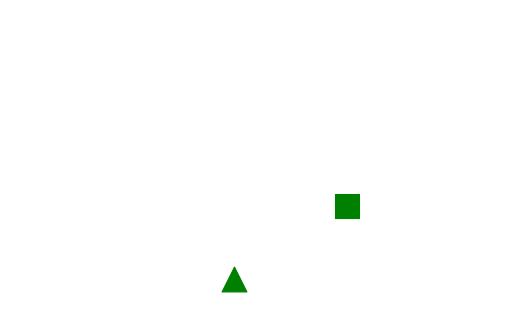

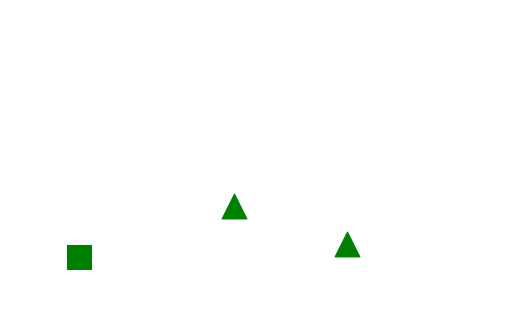

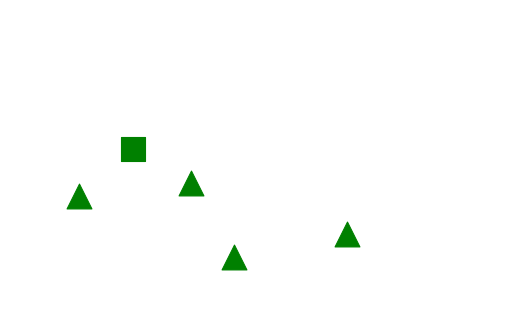

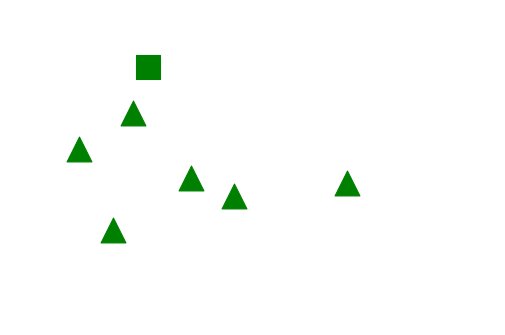

In [70]:
experiment_type = 'feature'
feature_time_ls = []
for TRIANGLES, SQUARES in zip(trils, sqls):
    start_time = time.time()    
    ####
    generate_plot(TRIANGLES, SQUARES, TRIANGLES + SQUARES,  'feature')
    file_to_read = os.path.join(RESPONSE_FOLDER, 'size-' + str(TRIANGLES + SQUARES)+  'simulation-' + experiment_type +'.jpg')
    simulation(TRIANGLES, SQUARES, TRIANGLES + SQUARES, file_to_read , experiment_type)
    
    for i in range(TRIANGLES + SQUARES):
        SIZE = TRIANGLES + SQUARES
        filename = os.path.join(RESPONSE_FOLDER, 'size-' + str(SIZE) + '-' + experiment_type +'-'+str(i) + '.jpg')
        result = corners(filename)
        sq_or_triangle(result)
        
    #######
    end_time = time.time()
    print("total time taken this loop: ", end_time - start_time)
    feature_time_ls.append(end_time - start_time)  

2
3
[12.936319    0.05291748]
[ 0.1528199 24.816309 ]
[25.846903 24.799417]
The given shape is triangle
4
[0.59342855 0.56861615]
[25.432562   0.5990451]
[ 0.60342973 25.42747   ]
[25.412504 25.419977]
The given shape is Square
total time taken this loop:  0.07163214683532715
3
4
[0.5788308 0.5848373]
[25.405304    0.59257925]
[ 0.5850402 25.428432 ]
[25.416538 25.417608]
The given shape is Square
3
[12.97534     0.11043224]
[ 0.16409792 24.757524  ]
[25.842768 24.815577]
The given shape is triangle
3
[12.970917    0.09218226]
[ 0.14650466 24.77771   ]
[25.864958 24.819008]
The given shape is triangle
total time taken this loop:  0.059008121490478516
5
3
[12.961792    0.07404327]
[ 0.1628054 24.809517 ]
[25.857187 24.833773]
The given shape is triangle
3
[12.9733715   0.12354638]
[ 0.14355832 24.846796  ]
[25.86137  24.861496]
The given shape is triangle
3
[13.014805    0.07627121]
[ 0.15555172 24.771618  ]
[25.840696 24.799604]
The given shape is triangle
3
[13.021727    0.10499463]
[

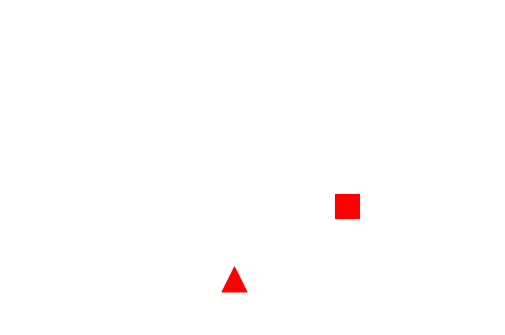

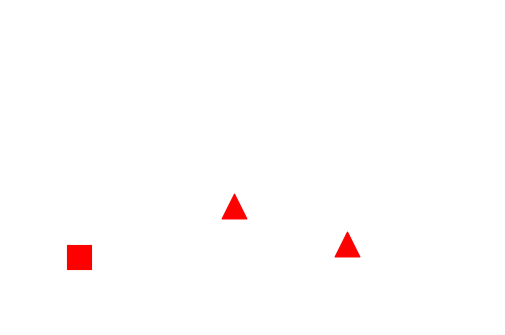

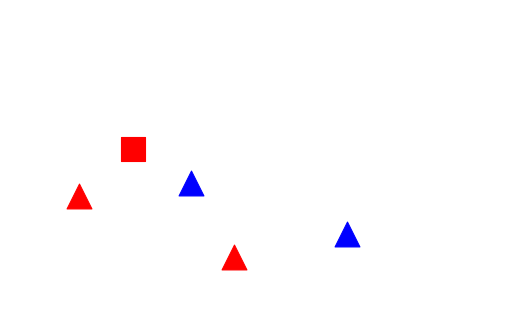

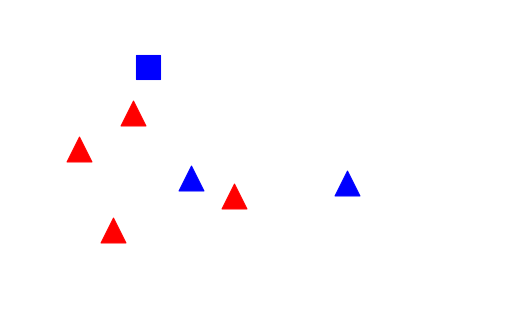

In [72]:
experiment_type = 'conjunction'
conjunction_time_ls = []
for TRIANGLES, SQUARES in zip(trils, sqls):
    start_time = time.time()    
    ####
    #finding shape
    generate_plot(TRIANGLES, SQUARES, TRIANGLES + SQUARES,  'conjunction')
    file_to_read = os.path.join(RESPONSE_FOLDER, 'size-' + str(TRIANGLES + SQUARES)+  'simulation-' + experiment_type +'.jpg')
    simulation(TRIANGLES, SQUARES, TRIANGLES + SQUARES, file_to_read , experiment_type)
    
    for i in range(TRIANGLES + SQUARES):
        SIZE = TRIANGLES + SQUARES
        filename = os.path.join(RESPONSE_FOLDER, 'size-' + str(SIZE) + '-' + experiment_type +'-'+str(i) + '.jpg')
        result = corners(filename)
        sq_or_triangle(result)
        time.sleep(0.0001)
    #adding delay
    time.sleep(0.0001)
    #finding color 
    
    #######
    end_time = time.time()
    print("total time taken this loop: ", end_time - start_time)
    conjunction_time_ls.append(end_time - start_time)  

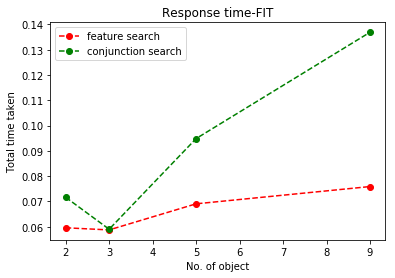

In [76]:
plt.plot(sizels, feature_time_ls, 'ro--', label = 'feature search')
plt.plot(sizels, conjunction_time_ls, 'go--', label = 'conjunction search')
plt.xlabel("No. of object")
plt.ylabel("Total time taken")
plt.legend()
plt.title("Response time-FIT")
plt.savefig("response-time.jpg")